In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


In [2]:
df = pd.read_parquet("green_tripdata_2022-02.parquet")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69399 entries, 0 to 69398
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               69399 non-null  int64         
 1   lpep_pickup_datetime   69399 non-null  datetime64[us]
 2   lpep_dropoff_datetime  69399 non-null  datetime64[us]
 3   store_and_fwd_flag     61978 non-null  object        
 4   RatecodeID             61978 non-null  float64       
 5   PULocationID           69399 non-null  int64         
 6   DOLocationID           69399 non-null  int64         
 7   passenger_count        61978 non-null  float64       
 8   trip_distance          69399 non-null  float64       
 9   fare_amount            69399 non-null  float64       
 10  extra                  69399 non-null  float64       
 11  mta_tax                69399 non-null  float64       
 12  tip_amount             69399 non-null  float64       
 13  t

In [3]:
df = df.drop(columns=['ehail_fee'], errors='ignore')


In [4]:
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60
df['weekday'] = df['lpep_dropoff_datetime'].dt.day_name()
df['hourofday'] = df['lpep_dropoff_datetime'].dt.hour


In [5]:
print(df['weekday'].value_counts())
print(df['hourofday'].value_counts())


weekday
Friday       11087
Thursday     10921
Wednesday    10409
Saturday      9998
Tuesday       9822
Monday        9717
Sunday        7445
Name: count, dtype: int64
hourofday
17    5286
16    5216
18    5205
15    4656
14    4527
19    4474
13    4110
12    3933
11    3880
10    3870
9     3815
20    3517
8     3360
21    2620
7     2308
22    2151
23    1746
0     1323
1      840
6      830
2      607
3      424
4      400
5      301
Name: count, dtype: int64


In [6]:
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna("Unknown", inplace=True)


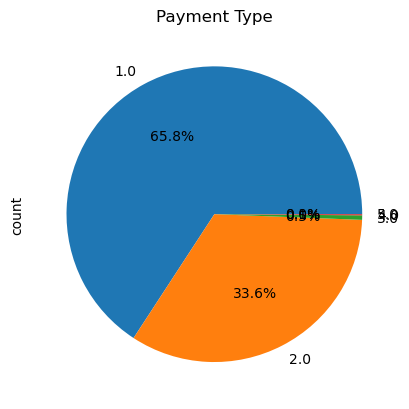

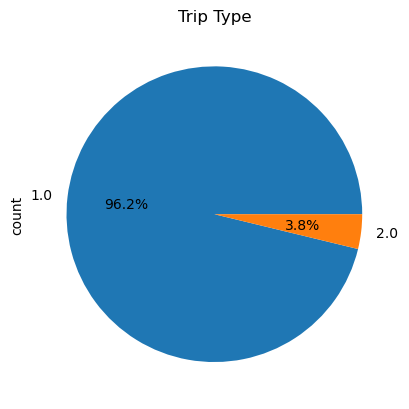

In [7]:
df['payment_type'].value_counts().plot.pie(autopct='%1.1f%%', title='Payment Type')
plt.show()

df['trip_type'].value_counts().plot.pie(autopct='%1.1f%%', title='Trip Type')
plt.show()


In [8]:
print(df.groupby('weekday')['total_amount'].mean())
print(df.groupby('payment_type')['total_amount'].mean())
print(df.groupby('weekday')['tip_amount'].mean())
print(df.groupby('payment_type')['tip_amount'].mean())


weekday
Friday       17.931055
Monday       17.476275
Saturday     17.981769
Sunday       18.192694
Thursday     17.715477
Tuesday      17.559875
Wednesday    17.748912
Name: total_amount, dtype: float64
payment_type
1.0    19.481800
2.0    14.781230
3.0    -0.206047
4.0     4.714881
5.0    28.800000
Name: total_amount, dtype: float64
weekday
Friday       1.840722
Monday       1.749103
Saturday     1.951963
Sunday       1.944564
Thursday     1.760558
Tuesday      1.698438
Wednesday    1.705155
Name: tip_amount, dtype: float64
payment_type
1.0    2.738770
2.0    0.000077
3.0   -0.028850
4.0    0.000000
5.0    0.000000
Name: tip_amount, dtype: float64


In [9]:
from scipy.stats import f_oneway, chi2_contingency

# l) ANOVA for trip_type
f_oneway_result = f_oneway(*[group['total_amount'].dropna() for name, group in df.groupby('trip_type')])
print("ANOVA Trip Type:", f_oneway_result)

# m) ANOVA for weekday
f_oneway_result = f_oneway(*[group['total_amount'].dropna() for name, group in df.groupby('weekday')])
print("ANOVA Weekday:", f_oneway_result)

# n) Chi-square test
contingency_table = pd.crosstab(df['trip_type'], df['payment_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-Square between Trip Type & Payment Type:", chi2, p)


ANOVA Trip Type: F_onewayResult(statistic=1379.7238154109273, pvalue=4.7009299407391036e-299)
ANOVA Weekday: F_onewayResult(statistic=2.854047387519063, pvalue=0.008842847624055534)
Chi-Square between Trip Type & Payment Type: 30.45621957044058 3.9516992774901776e-06


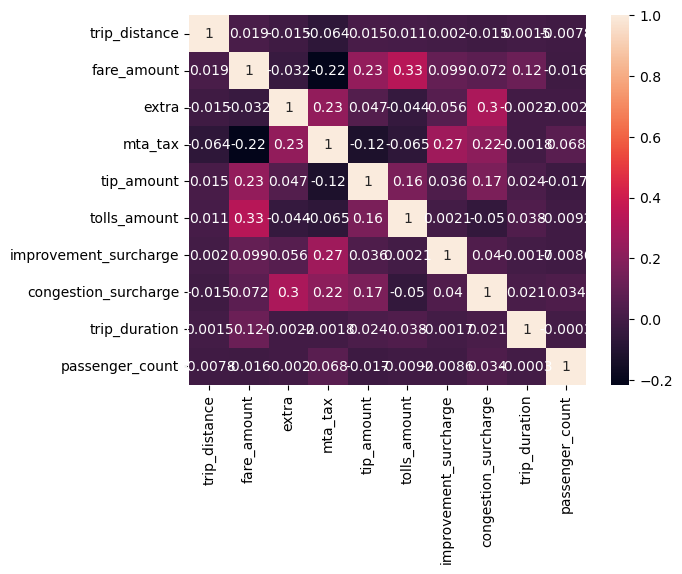

In [10]:
numeric_cols = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
                'improvement_surcharge', 'congestion_surcharge', 'trip_duration', 'passenger_count']
sns.heatmap(df[numeric_cols].corr(), annot=True)
plt.show()


In [11]:
df_encoded = pd.get_dummies(df, columns=[
    'store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type', 'weekday', 'hourofday'
])


In [12]:
features = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
            'improvement_surcharge', 'congestion_surcharge', 'trip_duration', 'passenger_count'] + \
           [col for col in df_encoded.columns if col.startswith(('store_and_fwd_flag_', 'RatecodeID_', 'payment_type_', 'trip_type_', 'weekday_', 'hourofday_'))]

X = df_encoded[features]
y = df_encoded['total_amount']

X = X.fillna(0)
y = y.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


R² Score: 0.9989646407478545
MSE: 0.23387763215323573


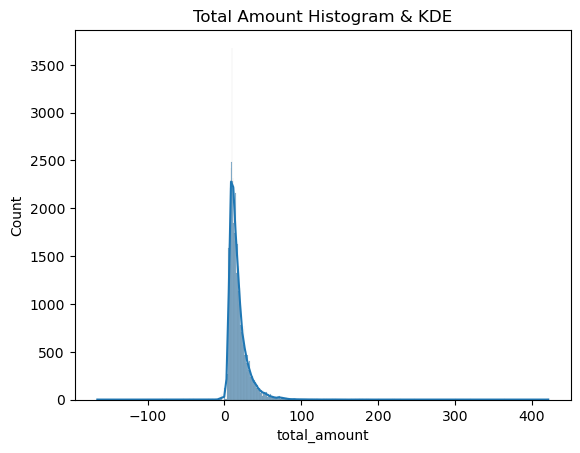

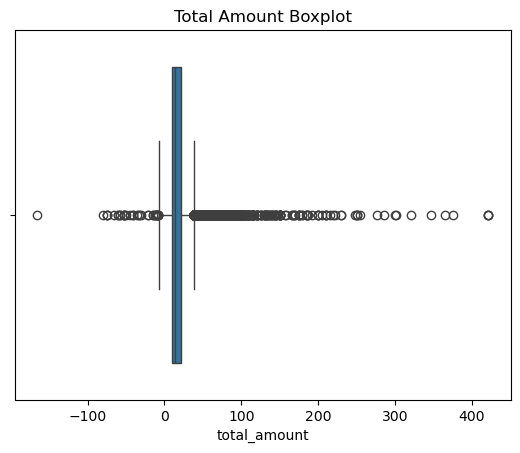

In [13]:
sns.histplot(df['total_amount'], kde=True)
plt.title("Total Amount Histogram & KDE")
plt.show()

sns.boxplot(x=df['total_amount'])
plt.title("Total Amount Boxplot")
plt.show()
